In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [147]:
def display_image(img, cmap=None):
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image, cmap=cmap)


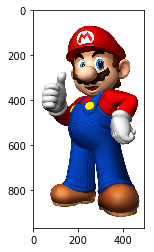

In [377]:
img = cv2.imread('mario.jpg')
display_image(img)


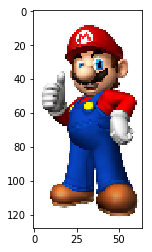

In [378]:
img = cv2.resize(img, (64, 128))
display_image(img)


In [379]:
def display_gradient(gx, gy, mag):
    plt.figure()
    plt.subplot(1, 3, 1)
    display_image(gx)

    plt.subplot(1, 3, 2)
    display_image(gy)

    plt.subplot(1, 3, 3)
    display_image(mag)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


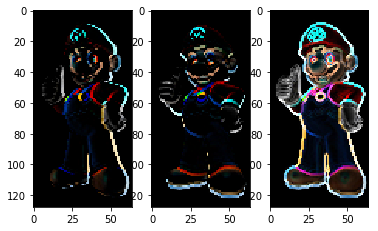

In [380]:
# normalize [0:255] to [0:1]
img = np.float32(img) / 255.0

# Calculate gradient 
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)

mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
display_gradient(gx, gy, mag)


In [381]:
h_bin_n = 20
h_bin = np.int32(angle / (360.0 / h_bin_n))

bin_cells = []
mag_cells = []

cell_x = cell_y = 8

for i in range(0, int(img.shape[0] / cell_y)):
    for j in range(0, int(img.shape[1] / cell_x)):
        bin_cells.append(h_bin[i * cell_y: i * cell_y + cell_y, j * cell_x: j * cell_x + cell_x])
        mag_cells.append(mag[i * cell_y: i * cell_y + cell_y, j * cell_x: j * cell_x + cell_x])


In [382]:
hists = [np.bincount(b.ravel(), m.ravel(), h_bin_n) for b, m in zip(bin_cells, mag_cells)]
hist = np.hstack(hists)


In [383]:
# transform to Hellinger kernel
eps = 1e-7
d_hist = hist / (hist.sum() + eps)
hist /= hist.sum() + eps
hist = np.sqrt(hist)
hist /= np.linalg.norm(hist) + eps


In [387]:
def draw_feature(img, start_x, start_y, block_size, features, bin_n):
    c_x, c_y = int(start_x + block_size / 2), int(start_y + block_size / 2)
    angle_divide = 2 * np.pi / bin_n
    for idx, feature in enumerate(features):
        length = feature/0.1 * block_size / 2 
        angle = idx * angle_divide
        cv2.line(img, (c_x, c_y), (c_x + int(np.cos(angle) * length), c_y + int(np.sin(angle) * -length)), (0, 255, 0), 3)


In [386]:
def display_hog(origin_img, hog_img):
    plt.figure()
    plt.subplot(1, 2, 1)
    display_image(origin_img)

    plt.subplot(1, 2, 2)
    display_image(hog_img)


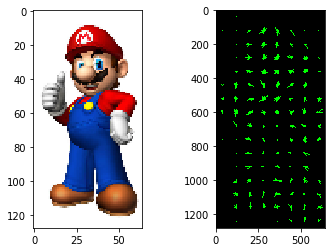

In [388]:
scale = 10
hog_w = img.shape[1] * scale
hog_h = img.shape[0] * scale
block_size = cell_x * scale
hog_img = np.zeros((hog_h, hog_w, 3), np.uint8)
for i in range(0, int(hog_h / block_size)):
    for j in range(0, int(hog_w / block_size)):
        features = hist[
                   (i * int(hog_w / block_size) + j) * h_bin_n:(i * int(hog_w / block_size) + j + 1) * h_bin_n]
        draw_feature(hog_img, j * block_size, i * block_size, block_size, features, h_bin_n)

display_hog(img, hog_img)
